In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/home/scidb/HeartRatePatterns/Python"))
from LogisticRegresion import ajustLogisticRegression
from PlotWords import plot_word
from Matrix import convert_matrix
from NMF import generateNMF,find_best_NMF

In [2]:
def findpatient(message,table,beats):
    groupsize = table.shape[0]
    deads = sum(table.index.labels[1].tolist())
    percent = -1 if groupsize==0 else deads/groupsize
    if groupsize!=0:
        print(message,"groupsize:%d"%groupsize,"deads:%d"%deads,"percent:{0:.2%}".format(percent),beats)

In [3]:
import psycopg2
def selectPearson(word,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_statement='SELECT patient,deadpatient,p1 FROM wordspearson WHERE word = %s'
#    print(cur.mogrify(select_statement,locals()))
    cur.execute(select_statement,(word,))
    select = {}
    for row in cur :
        patient=row[0]
        select = {'word':word,"pacientes":patient,"porcentaje de muertos":"{0:.2%}".format(row[1]/patient),"p1":row[2]}
    cur.close()
    conn.close()
    return select

In [4]:
def print_top_words(model, feature_names,topic_index=None):
    result = []
    for topic_idx, topic in enumerate(components):
        features = [{"word":feature_names[i],"p1":topic[i]} 
                    for i in topic.argsort()[:-1] if topic[i] > 0]
        if features!=[] and (topic_index==None or topic_index==topic_idx): result.append({"topic":topic_idx,"features":features})
    return result

In [5]:
def addValue(key,my_dict):
    if key in my_dict:
        my_dict[key] += 1
    else:
        my_dict[key] = 1
    return my_dict

In [6]:
table = convert_matrix(with_pearson=True) #.iloc[:,:400]
survived = table.index.labels[1].tolist()
patients = table.values
table

(554, 400)


,,aaadc,aabadd,aabaf,aabafb,aabaga,aabbg,aabbgb,aabdab,aabdad,aabdb,...,hag,haj,hbf,hdd,hddd,hfa,hfg,hga,hgd,jag
subject_id,isAlive,,,,,,,,,,,,,,,,,,,,,
135,1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
151,1,0,1,0,0,2,0,0,2,0,2,...,0,0,0,0,0,0,0,0,0,0
177,1,0,0,0,0,0,0,0,1,0,7,...,0,0,0,0,0,0,0,0,0,0
214,1,0,0,2,0,1,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
263,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
279,1,0,0,0,0,0,0,0,1,0,6,...,0,0,0,0,0,0,0,0,0,0
283,1,0,1,0,0,0,0,0,2,0,2,...,0,0,0,0,0,0,0,0,0,0
368,1,0,0,1,1,1,1,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
377,1,1,1,2,1,3,0,0,8,2,16,...,0,0,0,1,1,1,0,0,0,0


In [7]:
from sklearn.model_selection import train_test_split
patients_train, patients_test,survived_train, survived_test = train_test_split(patients,survived,test_size=0.2, random_state=42)

In [8]:
model,acurracy,logit_roc_auc = ajustLogisticRegression(patients_train,survived_train,patients_test,survived_test)

In [9]:
def countPatients(word,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_statement='''SELECT count(1),sum(isalive) FROM matrix m LEFT JOIN subjectwords s 
    ON m.subject_id=s.subject_id where m.word = %s GROUP BY m.word'''
#    print(cur.mogrify(select_statement,(word,)))
    cur.execute(select_statement,(word,))
    select = {}
    for row in cur :
        select = {"patient":row[0],"deadPatient":row[1],}
    cur.close()
    conn.close()
    return select

In [10]:
from scipy.stats.stats import pearsonr
columns = list(table.columns.values)
pearsonList = []
for i in range(len(columns)):
    pearson = pearsonr(patients[:,i],survived)
    word = columns[i]
    count = countPatients(word)
    deadPatient,patient = count['deadPatient'],count['patient']
    percent = deadPatient/patient
    pearsonList.append({'word':word,'correlación':pearson[0],'p-valor':pearson[1],'pacientes muertos':"{0:.2%}".format(percent)+" de %d" %patient})

In [11]:
from operator import itemgetter
pearsonList = sorted(pearsonList, key=itemgetter('correlación'), reverse=True)
pearsonList
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)

df = pd.DataFrame(pearsonList)
df = df.set_index('word')
df = df.sort_values(['correlación'], ascending=[False])
df

,correlación,p-valor,pacientes muertos
word,,,
babaaf,0.14448,0.00065,90.11% de 91
babaf,0.13705,0.00122,84.00% de 150
ababaf,0.13675,0.00125,90.10% de 101
abbg,0.13498,0.00145,86.57% de 134
fbabd,0.13318,0.00168,97.44% de 39
abaf,0.13287,0.00172,81.18% de 287
dafaab,0.13162,0.00191,95.35% de 43
bababf,0.13056,0.00207,87.36% de 87
fbbaba,0.12763,0.00262,89.47% de 95


{'pearson': 0.05376539303670632, 'diffErr': None, 'accuracy': 0.78378378378378377, 'roc_auc': 0.5, 'recostrucción error': 2162.3655318943565, 'n_components': 2}
{'pearson': 0.097055800137172007, 'diffErr': 440.15960104444525, 'accuracy': 0.78378378378378377, 'roc_auc': 0.5, 'recostrucción error': 1722.2059308499113, 'n_components': 3}
{'pearson': 0.090018400435492876, 'diffErr': 234.52210889286789, 'accuracy': 0.78378378378378377, 'roc_auc': 0.5, 'recostrucción error': 1487.6838219570434, 'n_components': 4}
{'pearson': 0.081563786972520536, 'diffErr': 214.44990071202324, 'accuracy': 0.78378378378378377, 'roc_auc': 0.5, 'recostrucción error': 1273.2339212450202, 'n_components': 5}
{'pearson': 0.079673449258838888, 'diffErr': 121.27194865084743, 'accuracy': 0.78378378378378377, 'roc_auc': 0.5, 'recostrucción error': 1151.9619725941727, 'n_components': 6}
{'pearson': 0.12737775530295065, 'diffErr': 71.658850984822038, 'accuracy': 0.78378378378378377, 'roc_auc': 0.5, 'recostrucción error':

{'pearson': 0.11563240238329764, 'diffErr': 3.3893473240239018, 'accuracy': 0.74774774774774777, 'roc_auc': 0.47701149425287354, 'recostrucción error': 300.89157736962125, 'n_components': 46}
{'pearson': 0.13093683979132412, 'diffErr': 3.2676572390707292, 'accuracy': 0.78378378378378377, 'roc_auc': 0.5, 'recostrucción error': 297.62392013055052, 'n_components': 47}
{'pearson': 0.11123601632780356, 'diffErr': 0.59834155080989149, 'accuracy': 0.77477477477477474, 'roc_auc': 0.4942528735632184, 'recostrucción error': 297.02557857974062, 'n_components': 48}
{'pearson': 0.10898602879795428, 'diffErr': 6.677871572346362, 'accuracy': 0.72972972972972971, 'roc_auc': 0.46551724137931033, 'recostrucción error': 290.34770700739426, 'n_components': 49}
{'pearson': 0.11789478519734453, 'diffErr': 5.2444714106479182, 'accuracy': 0.74774774774774777, 'roc_auc': 0.47701149425287354, 'recostrucción error': 285.10323559674634, 'n_components': 50}
{'pearson': 0.11428020761902029, 'diffErr': 1.82807987134

{'pearson': 0.12386758796756281, 'diffErr': 3.6598432113309798, 'accuracy': 0.77477477477477474, 'roc_auc': 0.4942528735632184, 'recostrucción error': 189.49582216575175, 'n_components': 90}
{'pearson': 0.12013908694364021, 'diffErr': 2.6203760898033295, 'accuracy': 0.69369369369369371, 'roc_auc': 0.44252873563218392, 'recostrucción error': 186.87544607594842, 'n_components': 91}
{'pearson': 0.12441114724116407, 'diffErr': 0.42183184664102669, 'accuracy': 0.76576576576576572, 'roc_auc': 0.4885057471264368, 'recostrucción error': 186.45361422930739, 'n_components': 92}
{'pearson': 0.12481007672869607, 'diffErr': 3.1222785155133295, 'accuracy': 0.76576576576576572, 'roc_auc': 0.4885057471264368, 'recostrucción error': 183.33133571379406, 'n_components': 93}
{'pearson': 0.12991094277381543, 'diffErr': -1.5210975011825667, 'accuracy': 0.7567567567567568, 'roc_auc': 0.48275862068965519, 'recostrucción error': 184.85243321497663, 'n_components': 94}
{'pearson': 0.12457430516869321, 'diffErr'

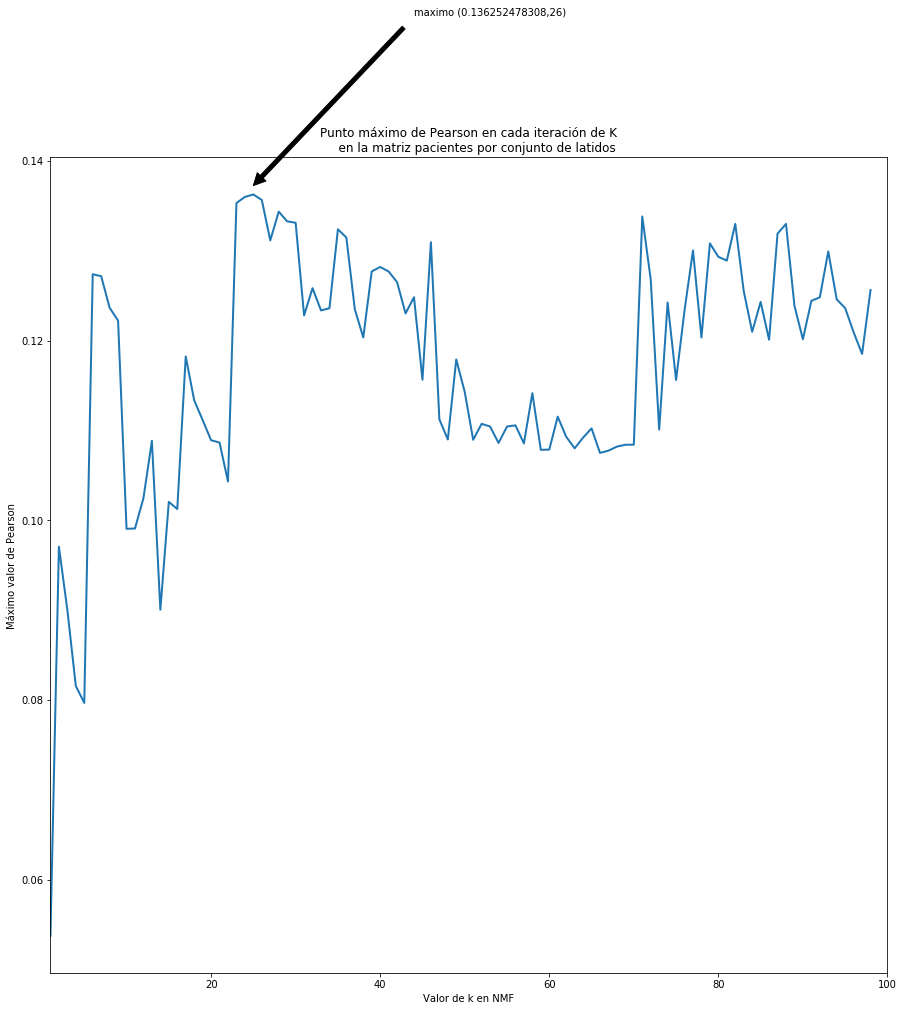

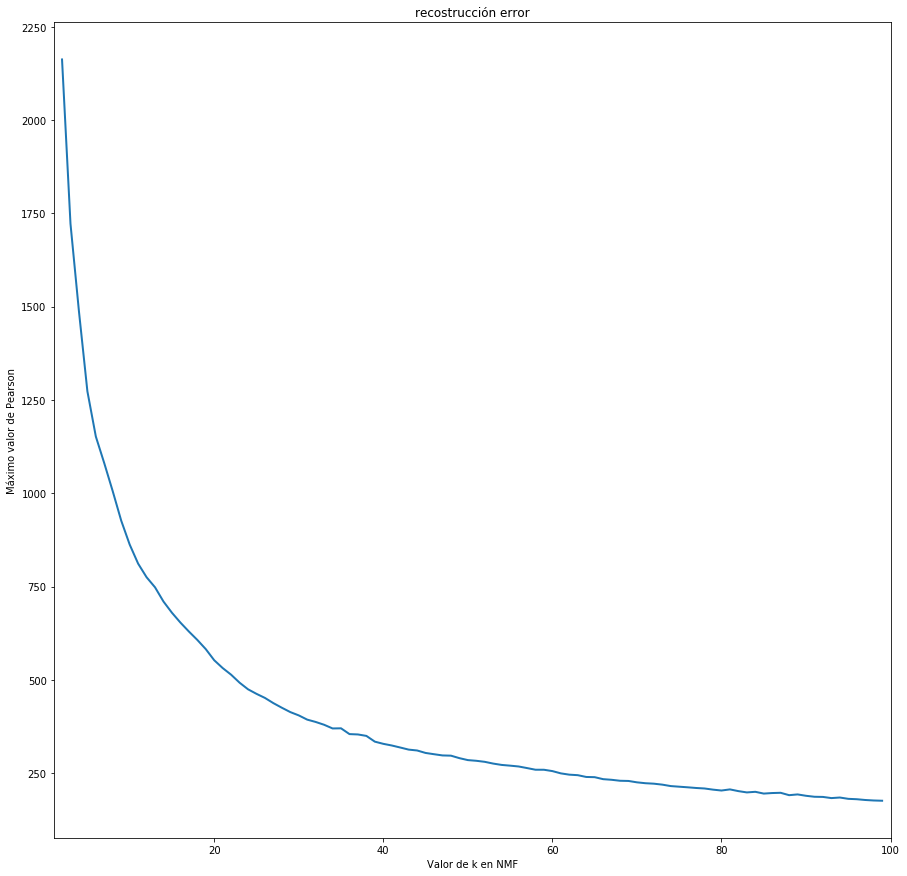

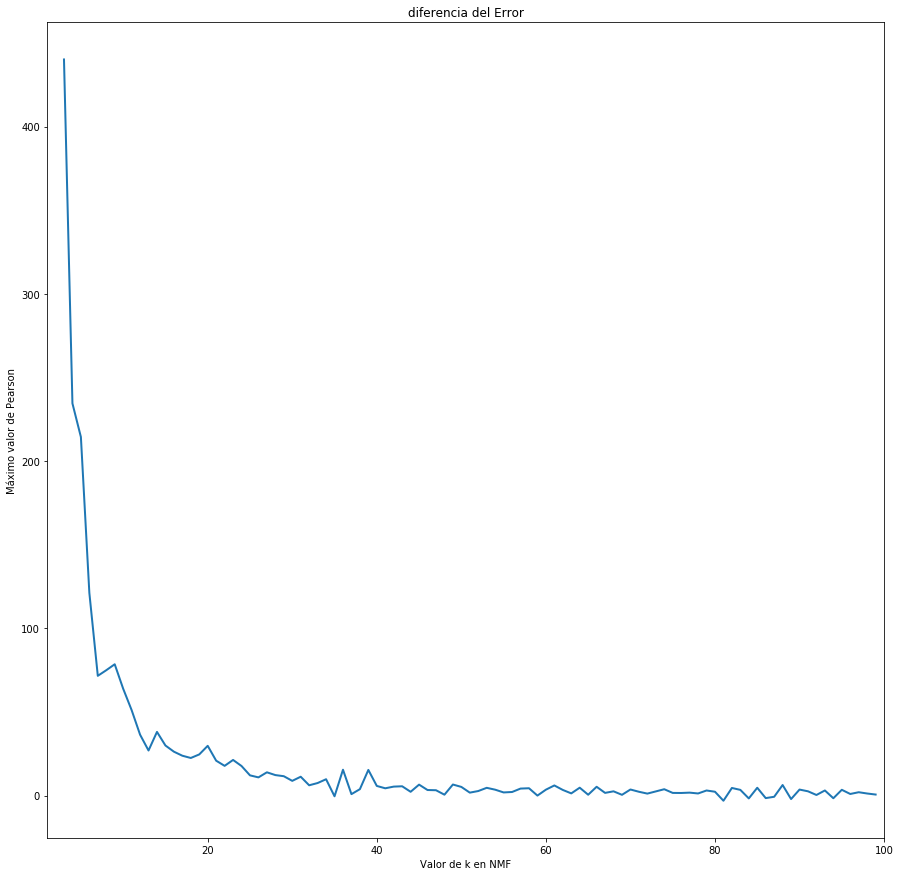

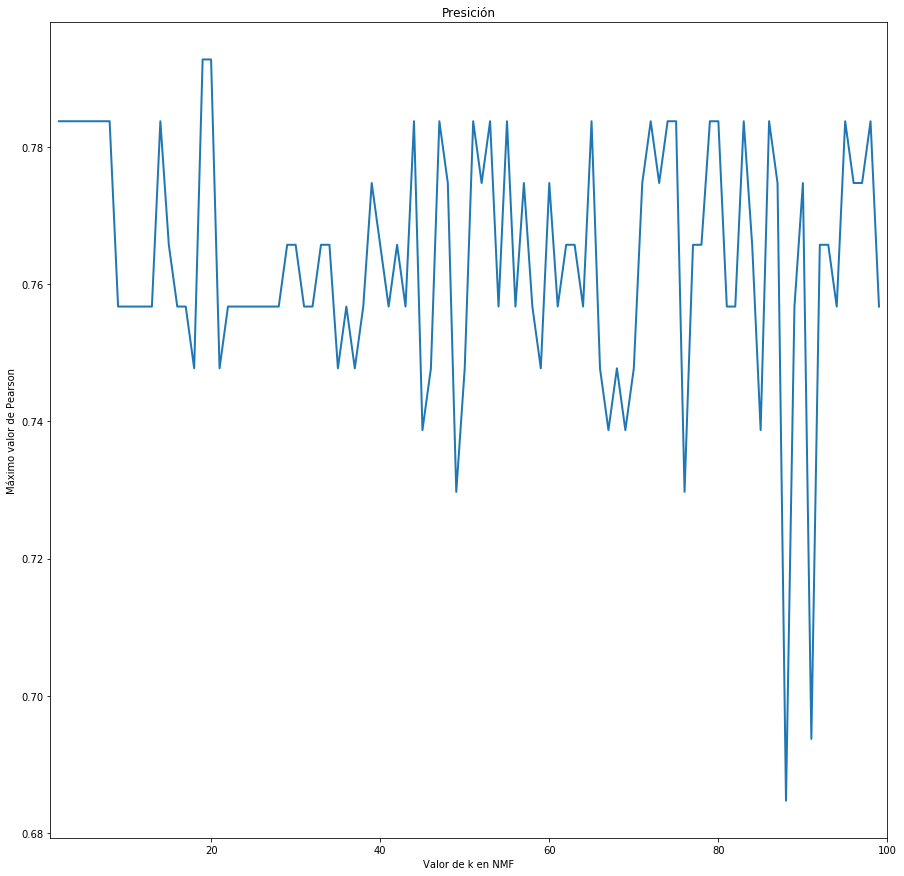

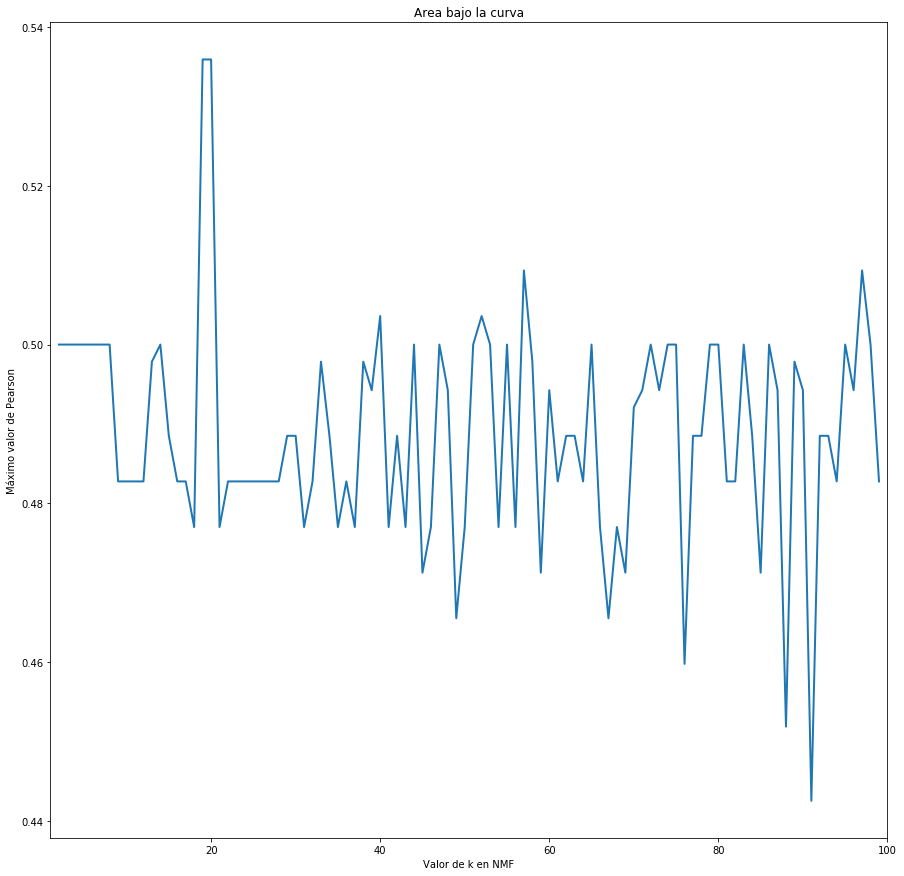

In [12]:
find_best_NMF(patients,survived)

In [13]:
import numpy as np
bestScore = 12
model, nmf, patients_nmf, acurracy, roc_auc = generateNMF(patients, survived, n_components=bestScore)
compoT = np.transpose(nmf.components_)
print("components",nmf.components_.shape)
print("components Transpose",compoT.shape)

components (12, 400)
components Transpose (400, 12)


In [14]:
from operator import itemgetter
def predict_proba(compoT,table,model):
    predicts = model.predict_proba(compoT)[:,1]
    beats = list(table)
    sortedBeats = []
    numPred = len(predicts)
    print(len(beats),numPred)
    nvals={}
    for i in range(0,numPred):
        word = beats[i]
        sel = selectPearson(word)
        if sel=={}:
            print("palabra no encontrada en pearson:",word)
        sortedBeats.append({'word':beats[i],'predict':predicts[i],'pacientes':sel['pacientes'],
                            'porcentaje de muertos':sel['porcentaje de muertos'],"correlación":sel['p1']})
        if predicts[i]>.99 : addValue("99",nvals)
        elif predicts[i]>.90 : addValue("90",nvals)
        elif predicts[i]>.80 : addValue("80",nvals)
        elif predicts[i]>.70 : addValue("70",nvals)
        else: addValue("under",nvals)
    print(nvals)
    return sorted(sortedBeats, key=itemgetter('correlación'), reverse=True)

In [15]:
sortedBeats = predict_proba(compoT,table,model)
beatKeys = []
for value in sortedBeats:
    beatKeys.append(value['word'])

400 400
{'80': 70, '70': 110, '90': 88, 'under': 67, '99': 65}


In [16]:
df = pd.DataFrame(sortedBeats)
df = df.set_index('word')
df = df.sort_values(['correlación'], ascending=[False])
df

,correlación,pacientes,porcentaje de muertos,predict
word,,,,
adc,0.20889,155,89.68%,0.99887
fdf,0.20378,83,96.39%,0.99931
dbda,0.18907,221,85.07%,0.59133
fbd,0.18370,165,87.27%,0.86346
dff,0.18014,88,93.18%,0.99897
ffd,0.17763,103,91.26%,0.99937
fff,0.17753,81,93.83%,0.99999
bdbd,0.17495,183,85.79%,0.02946
addaba,0.17329,106,90.57%,0.88175


Top 5 HeartBeats con mayor probabilidad de muerte según la regresión logística


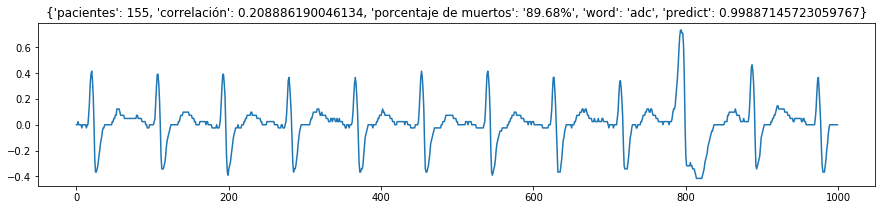

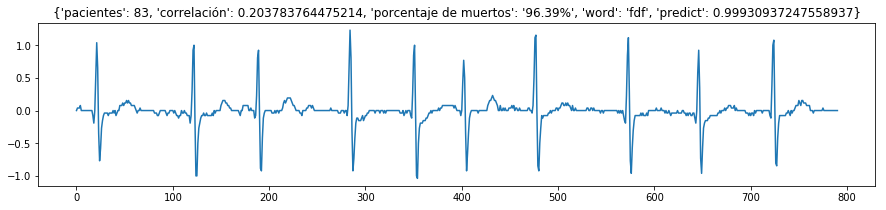

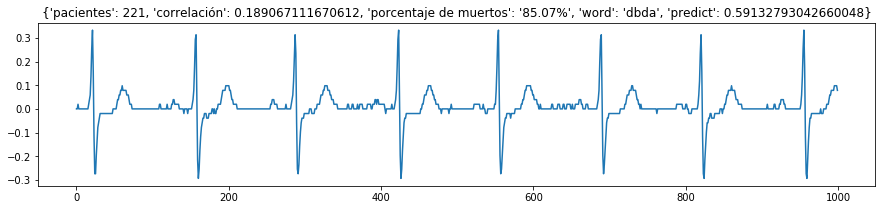

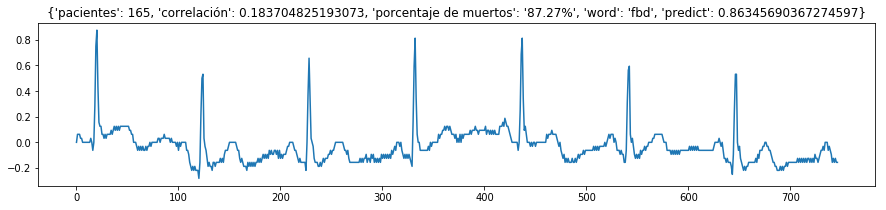

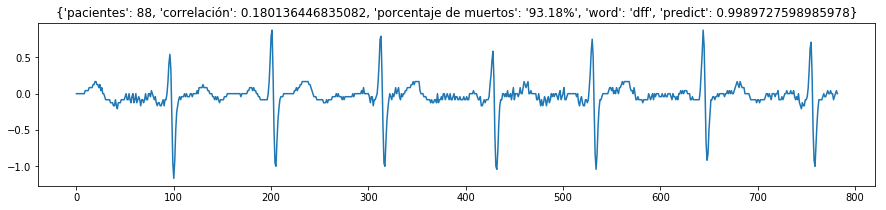

In [17]:
print("Top 5 HeartBeats con mayor probabilidad de muerte según la regresión logística")
plot_word(sortedBeats[:5])

In [18]:
from operator import itemgetter
from scipy.stats.stats import pearsonr
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)

def find_pearson(value, patient, survived):
    pearsonList = []
    for i in range(value):
        patientpear = patient[:, i]
        pearson = pearsonr(patientpear, survived)
        pearsonList.append({'grupo':i,'correlación':pearson[0],'p-valor':pearson[1]})
    return sorted(pearsonList, key=itemgetter('correlación'), reverse=True)

sortedList = find_pearson(bestScore,patients_nmf,survived)
#sortedList = sorted(pearsonList, key=itemgetter('p1'), reverse=True)
df = pd.DataFrame(sortedList)
df = df.set_index('grupo')
df = df.sort_values(['correlación'], ascending=[False])
df

,correlación,p-valor
grupo,,
4,0.09908,0.01967
6,0.09041,0.03337
3,0.08380,0.04868
11,0.07882,0.06374
2,0.05747,0.17680
5,0.05044,0.23595
0,0.04251,0.31791
7,0.03834,0.36779
9,0.03613,0.39604


In [19]:
columns = list(table)
components = nmf.components_
topword = print_top_words(components, columns,topic_index=sortedList[0]['grupo'])[0]['features']
subwords = []
for subword in topword:
    if subword['p1']>0:
        subwords.append(subword['word'])
print(str(subwords[:10]))

['fffa', 'hafa', 'agf', 'dabadb', 'fdfa', 'hfa', 'aaffd', 'ffda', 'fgh', 'gaj']


In [20]:
table = convert_matrix(sumvals=False,filter_words=tuple(subwords))
survived = table.index.labels[1].tolist()
patients = table.values
table

(553, 276)


,,aabadd,aabaf,aabafb,aabaga,aabbg,aabbgb,aabdab,aabdad,aabdb,aabdbb,...,gha,haf,hafa,hag,haj,hbf,hfa,hfg,hga,hgd
subject_id,isAlive,,,,,,,,,,,,,,,,,,,,,
135,1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
151,1,1,0,0,1,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
177,1,0,0,0,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
214,1,0,1,0,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
263,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
279,1,0,0,0,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
283,1,1,0,0,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
368,1,0,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
377,1,1,1,1,1,0,0,1,1,1,1,...,0,1,1,0,0,0,1,0,0,0


In [21]:
patients_train, patients_test,survived_train, survived_test = train_test_split(patients,survived,test_size=0.2, random_state=42)
print(table.shape)
print(patients_train.shape)
print(patients_test.shape)

(553, 276)
(442, 276)
(111, 276)


In [22]:
model, acurracy, roc_auc = ajustLogisticRegression(patients_train,survived_train,patients_test,survived_test)

In [23]:
columns = list(table.columns.values)
pearsonList = []
for i in range(len(columns)):
    pearson = pearsonr(patients[:,i],survived)
    word = columns[i]
    count = countPatients(word)
    deadPatient,patient = count['deadPatient'],count['patient']
    percent = deadPatient/patient
    pearsonList.append({'word':word,'correlación':pearson[0],'p-valor':pearson[1],'pacientes muertos':"{0:.2%}".format(percent)+" de %d" %patient})

In [24]:
df = pd.DataFrame(pearsonList)
df = df.set_index('word')
df = df.sort_values(['correlación'], ascending=[False])
df

,correlación,p-valor,pacientes muertos
word,,,
adc,0.20680,0.00000,89.68% de 155
fdf,0.20472,0.00000,96.39% de 83
dbda,0.18304,0.00001,85.07% de 221
fbd,0.17969,0.00002,87.27% de 165
dff,0.17956,0.00002,93.18% de 88
fff,0.17720,0.00003,93.83% de 81
ffd,0.17615,0.00003,91.26% de 103
addaba,0.17142,0.00005,90.57% de 106
haf,0.17138,0.00005,95.45% de 66
